# LIBRARIES

In [24]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from feature_engine.outliers import Winsorizer
import pickle
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score
from sklearn.metrics import classification_report,f1_score, recall_score, precision_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# DATA LOADING

## Load Dataset from GitHub

In [25]:
df = pd.read_csv(r'https://raw.githubusercontent.com/FTDS-assignment-bay/FTDS-007-HCK-group-002/main/dataset/data_clean_f9.csv')
df

,tenure_in_months,number_of_referrals,total_revenue,contract,offer,online_security,premium_tech_support,device_protection_plan,customer_status
0,9,2,974.81,One Year,None,No,Yes,No,Stayed
1,9,0,610.28,Month-to-Month,None,No,No,No,Stayed
2,4,0,415.45,Month-to-Month,Offer E,No,No,Yes,Churned
3,13,1,1599.51,Month-to-Month,Offer D,No,No,Yes,Churned
4,3,3,289.54,Month-to-Month,None,No,Yes,No,Churned
...,...,...,...,...,...,...,...,...,...
6584,4,0,93.54,Month-to-Month,None,No Internet,No Internet,No Internet,Churned
6585,13,0,1349.74,One Year,Offer D,Yes,Yes,No,Stayed
6586,22,1,2230.10,Month-to-Month,Offer D,No,No,No,Churned
6587,67,5,4769.69,Two Year,Offer A,Yes,Yes,Yes,Stayed


This data consist of 6589 rows in 9 columns

## Basic Exploration

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6589 entries, 0 to 6588
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tenure_in_months        6589 non-null   int64  
 1   number_of_referrals     6589 non-null   int64  
 2   total_revenue           6589 non-null   float64
 3   contract                6589 non-null   object 
 4   offer                   6589 non-null   object 
 5   online_security         6589 non-null   object 
 6   premium_tech_support    6589 non-null   object 
 7   device_protection_plan  6589 non-null   object 
 8   customer_status         6589 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 463.4+ KB


This data have 3 numeric & 5 object type

In [27]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure_in_months,6589.0,34.499772,23.968734,1.00,12.00,32.00,57.00,72.00
number_of_referrals,6589.0,2.020944,3.024016,0.00,0.00,0.00,3.00,11.00
total_revenue,6589.0,3235.218082,2854.600036,21.61,835.45,2376.45,5106.64,11979.34


From description here; data distribution in 'tenure_in_months' column are normaly distributed, and the other is not or skewed

# FEATURE ENGINEERING

## Change Target Values

In [28]:
# Change valus in target to 0 & 1 so the model could learn better
df['customer_status'] = df['customer_status'].replace({'Churned': 1, 'Stayed': 0})
df

,tenure_in_months,number_of_referrals,total_revenue,contract,offer,online_security,premium_tech_support,device_protection_plan,customer_status
0,9,2,974.81,One Year,None,No,Yes,No,0
1,9,0,610.28,Month-to-Month,None,No,No,No,0
2,4,0,415.45,Month-to-Month,Offer E,No,No,Yes,1
3,13,1,1599.51,Month-to-Month,Offer D,No,No,Yes,1
4,3,3,289.54,Month-to-Month,None,No,Yes,No,1
...,...,...,...,...,...,...,...,...,...
6584,4,0,93.54,Month-to-Month,None,No Internet,No Internet,No Internet,1
6585,13,0,1349.74,One Year,Offer D,Yes,Yes,No,0
6586,22,1,2230.10,Month-to-Month,Offer D,No,No,No,1
6587,67,5,4769.69,Two Year,Offer A,Yes,Yes,Yes,0


In [29]:
df_model = df.copy()

## Numeric & Object Column Define

In [30]:
# Define which numeric and object
# Object
obj_col = ['contract', 
            'offer', 
            'online_security', 
            'premium_tech_support',
            'device_protection_plan']
# Numeric
num_col = ['tenure_in_months',
            'number_of_referrals', 
            'total_revenue']

## Train-Test Set Split

In [31]:
# Splitting target and feature

X = df_model.drop('customer_status',axis=1)
y = df_model['customer_status']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, # Test dataset would be 20% of the data
                                                 random_state=42,
                                                 stratify=y)

print('X train: ', X_train.shape)
print('X test: ', X_test.shape)
print('y train: ', y_train.shape)
print('y test: ', y_test.shape)

X train:  (5271, 8)
X test:  (1318, 8)
y train:  (5271,)
y test:  (1318,)


### Numeric & Object Column Define in Feature Train Set

In [32]:
X_train_num = X_train[num_col]
X_train_obj = X_train[obj_col]

display(X_train_num.head())
display(X_train_obj.head())

,tenure_in_months,number_of_referrals,total_revenue
2204,43,0,3479.07
545,62,0,2767.86
5197,1,0,77.91
3322,3,0,364.74
419,62,5,6870.55


,contract,offer,online_security,premium_tech_support,device_protection_plan
2204,Two Year,None,No,No,No
545,Two Year,None,No Internet,No Internet,No Internet
5197,Month-to-Month,Offer E,No,No,No
3322,Month-to-Month,Offer E,No,No,Yes
419,One Year,None,Yes,Yes,Yes


# MODELING

In this section we gonna do `preprocessing` so the features are ready to be trained in the model and then `modeling` which start from baseline (deafult), cross validate, then hyperparameter tuning to find the best parameter in the best model selected

## Preprocessing

### Outlier Handling

#### Data Distribution Check

Note:
- Normal distributed
- Non-normal distributed (Skewed)

In [33]:
# Skewness
skewed = []
normal_skew = []

for i in X_train_num:
    skew = df_model[i].skew()

    print('Skewness', i, 'is', skew)
    
    if skew >= 0.5:
        skewed.append(i)
    else:
        normal_skew.append(i)

print(' ')
print('SKEWED:', skewed)
print('NORMAL SKEW:', normal_skew)

Skewness tenure_in_months is 0.15546541076151624
Skewness number_of_referrals is 1.3956128380999253
Skewness total_revenue is 0.8558948735826288
 
SKEWED: ['number_of_referrals', 'total_revenue']
NORMAL SKEW: ['tenure_in_months']


2 of 3 numerical column are skewed and need to be handled bellow

In [34]:
num_col_skewed = ['number_of_referrals', 'total_revenue']

Skewed/Non-normal distributed columns saved in 'num_col_skewed'

#### Capping

Skewed columns are handled by capping becase we don't wanna lose any data & just mildly skewed

In [35]:
# Create a Winsorizer object
winsorizer = Winsorizer(capping_method='iqr', # Because for skewed distribution
                        tail='both',
                        fold=3)

# Fit the Winsorizer to the selected columns and transform the data
X_train[num_col_skewed] = winsorizer.fit_transform(X_train[num_col_skewed])

### Pipeline Defining

Numerical columns:
- Min Max Scaler due to 2 out of 3 numerical column are skewed

Categorical columns:
- One Hot Encoder due to all of object type column are categorical; not ordinal/have no hierarchy

In [36]:
full_pipeline = ColumnTransformer([
    ('num', 
     Pipeline([
         ('scaled', MinMaxScaler())]),
         num_col),
     
    ('obj', 
     Pipeline([
         ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))]),
         obj_col)
])

full_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaled', MinMaxScaler())]),
                                 ['tenure_in_months', 'number_of_referrals',
                                  'total_revenue']),
                                ('obj',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['contract', 'offer', 'online_security',
                                  'premium_tech_support',
                                  'device_protection_plan'])])

#### Applying Pipeline to Train & Test Set

In [37]:
# fit_transform to TRAIN set
X_train_transformed = full_pipeline.fit_transform(X_train)
display(X_train_transformed)
# transform to TEST set
X_test_transformed = full_pipeline.transform(X_test)
display(X_test_transformed)

array([[0.5915493 , 0.        , 0.29184931, ..., 1.        , 0.        ,
        0.        ],
       [0.85915493, 0.        , 0.23181502, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.00475237, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.6056338 , 0.63636364, 0.20340381, ..., 0.        , 1.        ,
        0.        ],
       [0.95774648, 0.18181818, 0.70190255, ..., 1.        , 0.        ,
        0.        ],
       [0.6056338 , 0.72727273, 0.40727441, ..., 0.        , 0.        ,
        1.        ]])

array([[0.16901408, 0.36363636, 0.09179326, ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.00682382, ..., 1.        , 0.        ,
        0.        ],
       [0.21126761, 0.        , 0.05106388, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.00861926, ..., 1.        , 0.        ,
        0.        ],
       [0.76056338, 0.        , 0.3895117 , ..., 1.        , 0.        ,
        0.        ],
       [0.07042254, 0.        , 0.05626532, ..., 1.        , 0.        ,
        0.        ]])

Transforming into data frame again

In [38]:
# Extract feature names for numerical columns
num_features = num_col  # 'num_col' should already contain the list of numerical column names

# Extract feature names for OneHotEncoded columns
onehot_columns = full_pipeline.named_transformers_['obj'].named_steps['ohe'].get_feature_names_out(input_features=obj_col)
# 'obj_col' should already contain the list of categorical column names

# Combine both lists
all_features = num_features + list(onehot_columns)

# Create DataFrame for transformed training set
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=all_features)
# Create DataFrame for transformed test set
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=all_features)

# Display transformed DataFrames
display(X_train_transformed_df)
display(X_test_transformed_df)

,tenure_in_months,number_of_referrals,total_revenue,contract_Month-to-Month,contract_One Year,contract_Two Year,offer_None,offer_Offer A,offer_Offer B,offer_Offer C,...,offer_Offer E,online_security_No,online_security_No Internet,online_security_Yes,premium_tech_support_No,premium_tech_support_No Internet,premium_tech_support_Yes,device_protection_plan_No,device_protection_plan_No Internet,device_protection_plan_Yes
0,0.591549,0.000000,0.291849,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.859155,0.000000,0.231815,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.000000,0.000000,0.004752,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.028169,0.000000,0.028964,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.859155,0.454545,0.578129,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,0.549296,0.727273,0.394556,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
5267,0.436620,0.818182,0.325774,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5268,0.605634,0.636364,0.203404,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5269,0.957746,0.181818,0.701903,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


,tenure_in_months,number_of_referrals,total_revenue,contract_Month-to-Month,contract_One Year,contract_Two Year,offer_None,offer_Offer A,offer_Offer B,offer_Offer C,...,offer_Offer E,online_security_No,online_security_No Internet,online_security_Yes,premium_tech_support_No,premium_tech_support_No Internet,premium_tech_support_Yes,device_protection_plan_No,device_protection_plan_No Internet,device_protection_plan_Yes
0,0.169014,0.363636,0.091793,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.000000,0.000000,0.006824,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.211268,0.000000,0.051064,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.450704,0.090909,0.334003,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.929577,0.000000,0.795120,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1313,0.140845,0.636364,0.091309,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1314,0.281690,0.727273,0.051300,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1315,0.000000,0.000000,0.008619,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1316,0.760563,0.000000,0.389512,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### Imbalance Handling

Checking target values distiction

In [39]:
df_model['customer_status'].value_counts()

0    4720
1    1869
Name: customer_status, dtype: int64

Value comparison in the target are quite balance (3:1), but we use oversampling technique so that the model could learn better.

We use `SMOTE` and not SMOTENC due to all the column values already in numerical because have applied to the pipeline

In [40]:
smote = SMOTE(random_state = 42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_transformed, y_train)
y_train_balanced.value_counts()

0    3776
1    3776
Name: customer_status, dtype: int64

The data target values already balance; the model could learn better

## Model Definition

Here we use 6 models listed bellow

In [41]:
model_knn = KNeighborsClassifier()
model_svm = SVC()
model_dt = DecisionTreeClassifier()
model_rf = RandomForestClassifier()
model_boost = GradientBoostingClassifier()
model_logreg = LogisticRegression()

### Baseline

Using default parameters of each model

In [42]:
# Results container
result = []

# List of models
models = [
    ('KNN', KNeighborsClassifier()),
    ('SVM', SVC()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('Logistic Regression', LogisticRegression())
]

# Looping each model to fit, predict, and collect results
for name, model in models:
    # Fit model
    model.fit(X_train_balanced, y_train_balanced)
    
    # Predict on training and test sets
    train_predictions = model.predict(X_train_balanced)
    test_predictions = model.predict(X_test_transformed)

    # Compute recall scores
    recall_train = recall_score(y_train_balanced, train_predictions)
    recall_test = recall_score(y_test, test_predictions)

    # Insert results to the list
    result.append({
        'Model': name,
        'Recall Score - Train Set': recall_train,
        'Recall Score - Test Set': recall_test
    })

# Convert the results list to a Pandas DataFrame and display it
result_df = pd.DataFrame(result)
result_df

,Model,Recall Score - Train Set,Recall Score - Test Set
0,KNN,0.932733,0.743316
1,SVM,0.859640,0.858289
2,Decision Tree,1.000000,0.695187
3,Random Forest,0.999735,0.676471
4,Gradient Boosting,0.903337,0.804813
5,Logistic Regression,0.862023,0.890374


### Cross Validation

Cross validate all the model

In [43]:
# Results container
results = []

# List of models
models = [
    ('KNN', model_knn, 5, None),
    ('SVM', model_svm, 5, None),
    ('Decision Tree', model_dt, 5, 42),
    ('Random Forest', model_rf, 5, 42),
    ('Gradient Boosting', model_boost, 5, 42),
    ('Logistic Regression', model_logreg, 5, 42)
]

# Looping each model to perform cross-validation and collect results
for name, model, cv, random_state in models:
    if random_state is not None:
        model.random_state = random_state
    
    recall_train = cross_val_score(model,
                                   X_train_balanced,
                                   y_train_balanced,
                                   cv=cv,
                                   scoring="recall")
    
    results.append({
        'Model': name,
        'Recall Score - Mean': recall_train.mean(),
        'Recall Score - Std': recall_train.std(),
        'Recall Score - Range Start': recall_train.mean() - recall_train.std(),
        'Recall Score - Range End': recall_train.mean() + recall_train.std()
    })

# Convert the results list to a Pandas DataFrame and sort it
results_df = pd.DataFrame(results)
sorted_results_df = results_df.sort_values(by='Recall Score - Mean', ascending=False)

# Display the sorted DataFrame
sorted_results_df

,Model,Recall Score - Mean,Recall Score - Std,Recall Score - Range Start,Recall Score - Range End
4,Gradient Boosting,0.887992,0.058848,0.829145,0.946840
0,KNN,0.885074,0.024436,0.860638,0.909510
3,Random Forest,0.878463,0.067724,0.810739,0.946187
5,Logistic Regression,0.862026,0.009808,0.852218,0.871835
1,SVM,0.857523,0.009245,0.848278,0.866768
2,Decision Tree,0.854371,0.079153,0.775218,0.933524


Top-3 best model/algorithm are Gradient Boosting, K-Nearest Neighbors, & Random Forest

We gonna test 3 of them in Hyperparameter Tuning using Random Search to find the best parameters and ofc the best model

### Hyperparameter Tuning

Here we testing Top-3 algorithm `Gradient Boosting`, `KNN`, & `Random Forest` model as best fit to the data and tuning each algorithms to find the better algorithm


In [44]:
# Prepare parameter grids for each model
random_search_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5],
    'bootstrap': [True, False],
}  # Random Forest parameters as previously defined
random_search_gb = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5],
    'subsample': [0.8, 0.9, 1.0]
}  # Gradient Boosting parameters
random_search_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'weights': ['uniform', 'distance']
} # KNN parameters as previously defined

# Combine models and their parameter grids
models_params = [
    ('Random Forest', RandomForestClassifier(), random_search_rf),
    ('Gradient Boosting', GradientBoostingClassifier(), random_search_gb),
    ('KNN', KNeighborsClassifier(), random_search_knn)
]

# Results container
all_results_tuning = []

# Loop through each model
for name, model, param_grid in models_params:
    num_combinations = 1
    for param_list in param_grid.values():
        num_combinations *= len(param_list)

    n_iter_search = min(50, num_combinations)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    random_search = RandomizedSearchCV(estimator=model,
                                       param_distributions=param_grid,
                                       n_iter=n_iter_search,  # Adjusted line
                                       cv=cv,
                                       random_state=42,
                                       n_jobs=-1,
                                       verbose=3,
                                       scoring='recall')
    
    # Fit the model
    random_search.fit(X_train_balanced, y_train_balanced)
    
    # Get the best estimator
    best_model = random_search.best_estimator_
    
    # Evaluate on the training and test set
    y_pred_train = best_model.predict(X_train_balanced)
    y_pred_test = best_model.predict(X_test_transformed)

    mean_test_score = random_search.cv_results_['mean_test_score'].mean()
    std_test_score = random_search.cv_results_['mean_test_score'].std()
    
    recall_train = recall_score(y_train_balanced, y_pred_train)
    recall_test = recall_score(y_test, y_pred_test)
    
    # Store the results
    all_results_tuning.append({
        'Model': name,
        'Train Recall': recall_train,
        'Test Recall': recall_test,
        'Best Params': random_search.best_params_,
        'Mean Test Score': mean_test_score,
        'Std Test Score': std_test_score
    })

# Convert results to DataFrame and display
import pandas as pd
results_df_tuning = pd.DataFrame(all_results_tuning)
results_df_tuning

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


,Model,Train Recall,Test Recall,Best Params,Mean Test Score,Std Test Score
0,Random Forest,0.931409,0.831551,"{'n_estimators': 200, 'min_samples_split': 10,...",0.883673,0.006519
1,Gradient Boosting,0.926112,0.791444,"{'subsample': 0.9, 'n_estimators': 50, 'min_sa...",0.884592,0.005446
2,KNN,1.000000,0.748663,"{'weights': 'distance', 'n_neighbors': 9, 'met...",0.888324,0.009210


Random Forest is the best algorithm

#### Result from Random Forest Random Search

In [45]:
# Sort the DataFrame by 'Test Recall' in descending order; thus the best parameters would be on top of the list (top row)
results_df_sorted = results_df_tuning.sort_values(by='Test Recall', ascending=False)

# Extract the top row
best_model_row = results_df_sorted.iloc[0]

# Get the model name and best parameters
best_model_name = best_model_row['Model']
best_model_params = best_model_row['Best Params']

print(f"The highest Test Recall is {best_model_name} with parameters: {best_model_params}")

The highest Test Recall is Random Forest with parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': False}


It shows that the best algoritm is `Random Forest`

With parameters:
- 'n_estimators': 200
- 'min_samples_split': 10
- 'min_samples_leaf': 1
- 'max_depth': 10
- 'bootstrap': False

In [46]:
# best_model_params contains the best parameters for RandomForest
best_rf_params = best_model_params

# Instantiate a new RandomForestClassifier with the best parameters
best_rf_model = RandomForestClassifier(**best_rf_params, random_state=42)

# Fit the model to the balanced training data
best_rf_model.fit(X_train_balanced, y_train_balanced)

# show parameter
best_rf_model

RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_split=10,
                       n_estimators=200, random_state=42)

# MODEL EVALUATION

## Confusion Matrix & Classification report

To show the class division capabilities of the model

RF - Recall Score - Train Set  :  0.9303495762711864 

RF - Classification Report : 
               precision    recall  f1-score   support

           0       0.92      0.85      0.88      3776
           1       0.86      0.93      0.89      3776

    accuracy                           0.89      7552
   macro avg       0.89      0.89      0.89      7552
weighted avg       0.89      0.89      0.89      7552
 



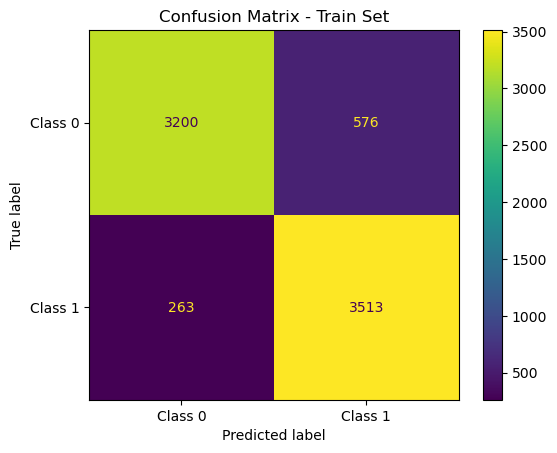

RF - Recall Score - Test Set  :  0.8288770053475936 

RF - Classification Report : 
               precision    recall  f1-score   support

           0       0.92      0.82      0.87       944
           1       0.64      0.83      0.72       374

    accuracy                           0.82      1318
   macro avg       0.78      0.82      0.80      1318
weighted avg       0.84      0.82      0.83      1318
 



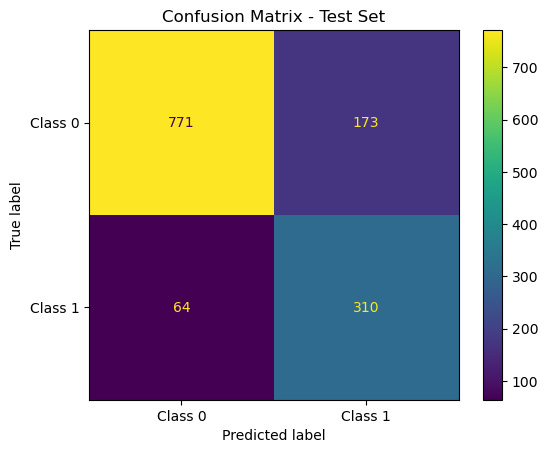

In [47]:
# Predict on training set and evaluate
y_pred_train_finals_rf = best_rf_model.predict(X_train_balanced)

print('RF - Recall Score - Train Set  : ', recall_score(y_train_balanced, y_pred_train_finals_rf), '\n')
print('RF - Classification Report : \n', classification_report(y_train_balanced, y_pred_train_finals_rf), '\n')

# Confusion Matrix for Train Set
cm_train = confusion_matrix(y_train_balanced, y_pred_train_finals_rf)
ConfusionMatrixDisplay(cm_train, display_labels=['Class 0', 'Class 1']).plot()
plt.title('Confusion Matrix - Train Set')
plt.show()

# Predict on test set and evaluate
y_pred_test_finals_rf = best_rf_model.predict(X_test_transformed)

print('RF - Recall Score - Test Set  : ', recall_score(y_test, y_pred_test_finals_rf), '\n')
print('RF - Classification Report : \n', classification_report(y_test, y_pred_test_finals_rf), '\n')

# Confusion Matrix for Test Set
cm_test = confusion_matrix(y_test, y_pred_test_finals_rf)
ConfusionMatrixDisplay(cm_test, display_labels=['Class 0', 'Class 1']).plot()
plt.title('Confusion Matrix - Test Set')
plt.show()


- Train Recall Score: `0.93`
- Test Recall Score: `83`

It shows that the model have good capalbilities dividing/predict the class

## Scoring

Comparing baseline score with the best parameter score

### Baseline

In [48]:
# Fit the model
model_rf.fit(X_train_balanced, y_train_balanced)

y_pred_train = model_rf.predict(X_train_balanced)  # replace 'model' and 'X_train_balanced' with your actual model and data
y_pred_test = model_rf.predict(X_test_transformed) 


all_reports = {}
def performance_report(all_reports, y_train, y_pred_train, y_test, y_pred_test, model_name):
    score_reports = {
        'train - precision': precision_score(y_train, y_pred_train),
        'train - recall': recall_score(y_train, y_pred_train),
        'train - accuracy': accuracy_score(y_train, y_pred_train),
        'train - f1_score': f1_score(y_train, y_pred_train),
        'test - precision': precision_score(y_test, y_pred_test),
        'test - recall': recall_score(y_test, y_pred_test),
        'test - accuracy': accuracy_score(y_test, y_pred_test),
        'test - f1_score': f1_score(y_test, y_pred_test),
    }
    all_reports[model_name] = score_reports
    return all_reports

# Example usage
all_reports = performance_report(
    all_reports, 
    y_train_balanced, 
    y_pred_train, # replace this with the actual predictions for the train set
    y_test, 
    y_pred_test, # replace this with the actual predictions for the test set
    'Baseline - RF' # replace this with the name of the model
)

pd.DataFrame(all_reports)

,Baseline - RF
test - accuracy,0.812595
test - f1_score,0.673712
test - precision,0.665796
test - recall,0.681818
train - accuracy,0.999735
train - f1_score,0.999735
train - precision,0.999471
train - recall,1.000000


### Random Search

In [49]:
all_reports = performance_report(all_reports, y_train_balanced, y_pred_train_finals_rf, y_test, y_pred_test_finals_rf, 'RandomSearch - RF')
pd.DataFrame(all_reports)

,Baseline - RF,RandomSearch - RF
train - precision,0.999471,0.859134
train - recall,1.000000,0.930350
train - accuracy,0.999735,0.888904
train - f1_score,0.999735,0.893325
test - precision,0.665796,0.641822
test - recall,0.681818,0.828877
test - accuracy,0.812595,0.820182
test - f1_score,0.673712,0.723454


- Train recall section shows that baseline more overfit
- Test recall section shows the best parameters have better capabilities

In summary, the best parameter have better quality than the baseline

## ROC (Receiver Operating Characteristic)

Random Forest - AUC

Evaluation scoring if we consider our data is `balanced`

AUC-ROC Score - Test Set :  0.9051892617601741 



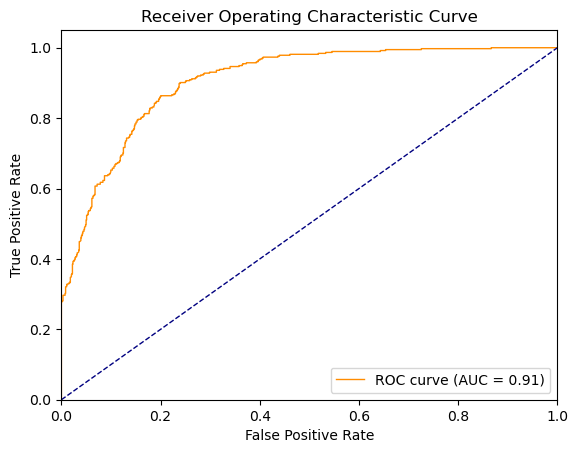

In [50]:
# Predict on test set and evaluate
y_pred_test_finals_rf = best_rf_model.predict(X_test_transformed)
y_pred_test_proba_rf = best_rf_model.predict_proba(X_test_transformed)[:, 1]  # Probabilities for the positive class

print('AUC-ROC Score - Test Set : ', roc_auc_score(y_test, y_pred_test_proba_rf), '\n')

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_proba_rf)

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

The model has good ROC Score (`0.91`)

## PR (Precision-Recall) Curve

Random Forest - PR CURVE

Evaluation scoring if we consider out data is `imbalanced`

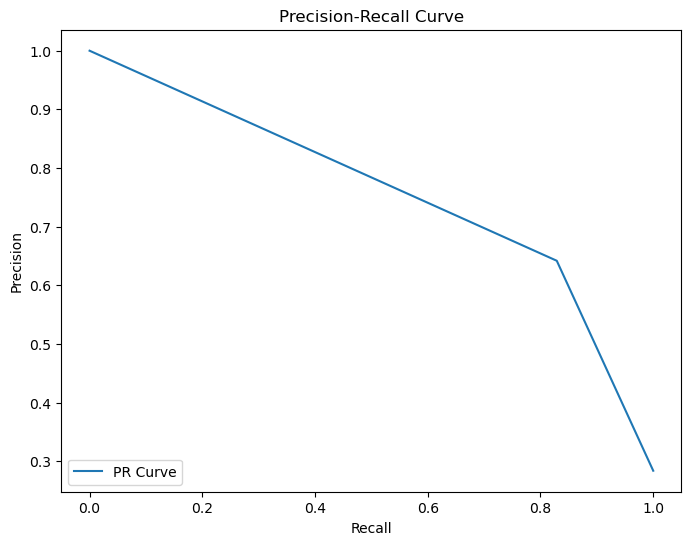

AUC of PR Curve: 0.76


In [51]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_test_finals_rf)

# Plotting the PR Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="PR Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

print(f"AUC of PR Curve: {auc(recall, precision):.2f}")

The model has quite good Precision-Recal-Score (`0.76`)

# MODEL SAVING

Save the pipeline we create and insert the best model

## Pipeline Check

### Current Pipeline

In [52]:
# Current Pipeline
full_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaled', MinMaxScaler())]),
                                 ['tenure_in_months', 'number_of_referrals',
                                  'total_revenue']),
                                ('obj',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['contract', 'offer', 'online_security',
                                  'premium_tech_support',
                                  'device_protection_plan'])])

### Insert Best Model

In [53]:
# Show best parameters
best_rf_model

RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_split=10,
                       n_estimators=200, random_state=42)

In [54]:
# Define Random Forest model which include best parameters
rf_model = RandomForestClassifier(
    n_estimators=200,       # The number of trees in the forest, 200 trees
    min_samples_split=10,   # Min number of samples required to split an internal node
    min_samples_leaf=1,     # Min number of samples required to be at a leaf node
    max_depth=10,           # The maximum depth of the tree, 10 level depth
    bootstrap=False,        # Whether bootstrap samples are used when building trees
    random_state=42
)

rf_model.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_split=10,
                       n_estimators=200, random_state=42)

In [55]:
# Inserting Model with Best Parameters
full_process = Pipeline([
    ("preprocess", full_pipeline),
    ("classification", rf_model)
])

full_process

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaled',
                                                                   MinMaxScaler())]),
                                                  ['tenure_in_months',
                                                   'number_of_referrals',
                                                   'total_revenue']),
                                                 ('obj',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['contract', 'offer',
                                                   'online_security',
                                                   'premium_tech_support',
                                                   'device_protection_plan'])])),
                ('classification',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        min_samples_split=10, n_estimators=200,
                                        random_state=42))])

## Save Pipeline Pickle

In [56]:
# Save the model
with open('fp_classifier.pkl', 'wb') as file:
    pickle.dump((full_process), file)